In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = 'F:/Alzheimers-ADNI/train'
TEST_DIR =  'F:/Alzheimers-ADNI/test'

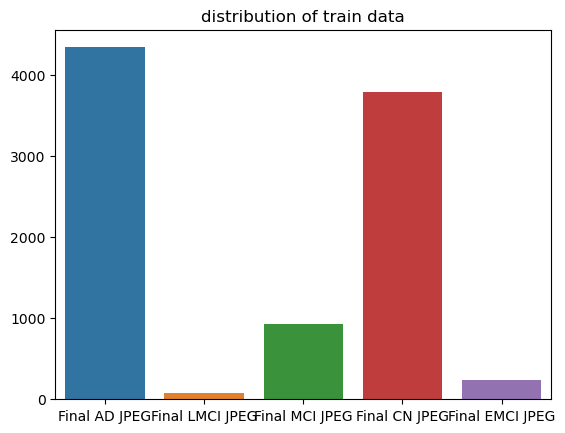

9350


In [13]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)

In [14]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

In [15]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 12961 images belonging to 5 classes.
Found 3239 images belonging to 5 classes.
Found 2575 images belonging to 5 classes.


In [16]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(input, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(input, output)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                           

In [19]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [20]:
h = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 85s 3s/step - loss: 1.6001 - accuracy: 0.5440 - val_loss: 3.8121 - val_accuracy: 0.3646
Epoch 2/10
27/27 [==============================] - 76s 3s/step - loss: 0.9449 - accuracy: 0.5428 - val_loss: 2.6681 - val_accuracy: 0.2552
Epoch 3/10
27/27 [==============================] - 75s 3s/step - loss: 0.7619 - accuracy: 0.6123 - val_loss: 3.5911 - val_accuracy: 0.2969
Epoch 4/10
27/27 [==============================] - 76s 3s/step - loss: 0.7415 - accuracy: 0.5775 - val_loss: 4.5074 - val_accuracy: 0.3073
Epoch 5/10
27/27 [==============================] - 76s 3s/step - loss: 0.7165 - accuracy: 0.5856 - val_loss: 4.9761 - val_accuracy: 0.2656
Epoch 6/10
27/27 [==============================] - 75s 3s/step - loss: 0.6974 - accuracy: 0.6111 - val_loss: 3.5857 - val_accuracy: 0.2604
Epoch 7/10
27/27 [==============================] - 74s 3s/step - loss: 0.6920 - accuracy: 0.6157 - val_loss: 3.8979 - val_accuracy: 0.2760
Epoch 8/10
27/27 [==

In [21]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [22]:
print(f"VGG16- number of layers: {len(base_model.layers)}")
for layer in base_model.layers:
    print(f"{layer.name} trainable? {layer.trainable}")

VGG16- number of layers: 19
input_3 trainable? False
block1_conv1 trainable? False
block1_conv2 trainable? False
block1_pool trainable? False
block2_conv1 trainable? False
block2_conv2 trainable? False
block2_pool trainable? False
block3_conv1 trainable? False
block3_conv2 trainable? False
block3_conv3 trainable? False
block3_pool trainable? False
block4_conv1 trainable? True
block4_conv2 trainable? True
block4_conv3 trainable? True
block4_pool trainable? True
block5_conv1 trainable? True
block5_conv2 trainable? True
block5_conv3 trainable? True
block5_pool trainable? True


In [23]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [24]:
h1 = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 137s 5s/step - loss: 2.4801 - accuracy: 0.4433 - val_loss: 0.9995 - val_accuracy: 0.3958
Epoch 2/10
27/27 [==============================] - 134s 5s/step - loss: 0.8277 - accuracy: 0.4826 - val_loss: 1.1464 - val_accuracy: 0.4271
Epoch 3/10
27/27 [==============================] - 135s 5s/step - loss: 0.7853 - accuracy: 0.4618 - val_loss: 1.2005 - val_accuracy: 0.4062
Epoch 4/10
27/27 [==============================] - 136s 5s/step - loss: 0.7977 - accuracy: 0.4560 - val_loss: 1.2122 - val_accuracy: 0.4219
Epoch 5/10
27/27 [==============================] - 135s 5s/step - loss: 0.7797 - accuracy: 0.5000 - val_loss: 1.2533 - val_accuracy: 0.1667
Epoch 6/10
27/27 [==============================] - 135s 5s/step - loss: 0.7747 - accuracy: 0.5289 - val_loss: 1.2319 - val_accuracy: 0.1719
Epoch 7/10
27/27 [==============================] - 135s 5s/step - loss: 0.7587 - accuracy: 0.5301 - val_loss: 1.2091 - val_accuracy: 0.3177
Epoch 8/10
27

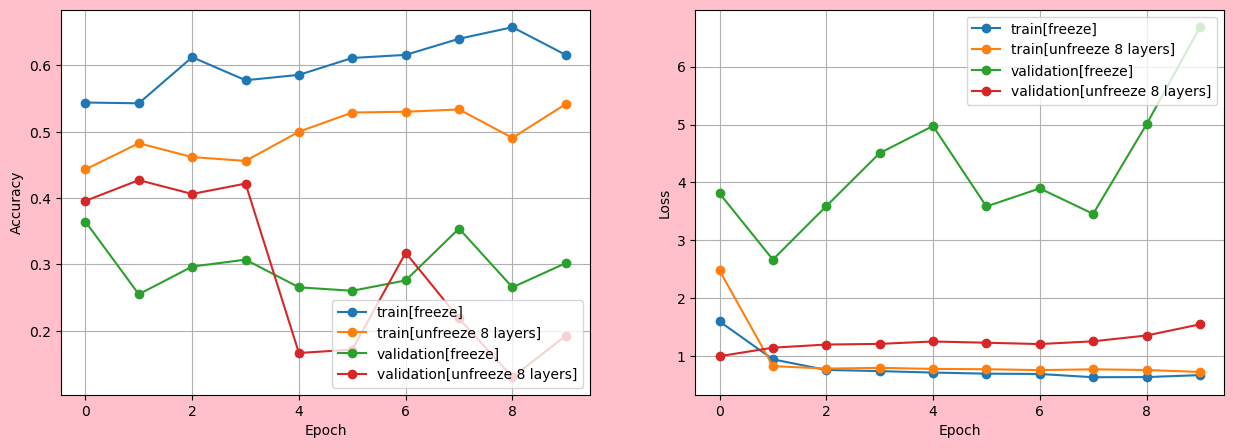

In [25]:
plt.figure(figsize=(15,5), facecolor='pink')
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train[freeze]')
plt.plot(h1.history['accuracy'], 'o-', label='train[unfreeze 8 layers]')

plt.plot(h.history['val_accuracy'], 'o-', label = 'validation[freeze]')
plt.plot(h1.history['val_accuracy'], 'o-', label = 'validation[unfreeze 8 layers]')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train[freeze]')
plt.plot(h1.history['loss'], 'o-', label='train[unfreeze 8 layers]')

plt.plot(h.history['val_loss'], 'o-', label='validation[freeze]')
plt.plot(h1.history['val_loss'], 'o-', label='validation[unfreeze 8 layers]')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()